In [1]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.v2 as v2

In [2]:
record_path=r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"

In [3]:
# cleaning the dataframe
df=pd.read_csv(record_path+r"\Data_Entry_2017.csv")
good=["Image Index","Finding Labels"]
df=df[good]
display(df)

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


In [4]:
# Getting all the deseases from the DF and creating one-hot encoding.
diseases=set()
for i in df["Finding Labels"].unique():
    z=i.split("|")
    for j in z:
        diseases.add(j)
print(diseases)
for i in diseases:
    df.loc[:,i]=0

for index,row in df.iterrows():
    labels= row["Finding Labels"].split("|")
    for i in labels:
        df.loc[index,i]=1
df=df.drop("Finding Labels",axis=1)
display(df)

{'Pleural_Thickening', 'Consolidation', 'No Finding', 'Emphysema', 'Pneumonia', 'Nodule', 'Atelectasis', 'Edema', 'Effusion', 'Hernia', 'Cardiomegaly', 'Pneumothorax', 'Mass', 'Fibrosis', 'Infiltration'}


,Image Index,Pleural_Thickening,Consolidation,No Finding,Emphysema,Pneumonia,Nodule,Atelectasis,Edema,Effusion,Hernia,Cardiomegaly,Pneumothorax,Mass,Fibrosis,Infiltration
0,00000001_000.png,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,00000001_001.png,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,00000001_002.png,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,00000002_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
112116,00030802_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# # we now create the training data frame using the list provided in the files.
# image_names_train= open(r"train_val_list.txt").read().split("\n")
# for i in image_names_train:
#     df_train=df[df["Image Index"].isin(image_names_train)]
# df_train.to_parquet("df_train.parquet")

In [6]:
# # we now create the training data frame using the list provided in the files.
# image_names_test= open(r"test_list.txt").read().split("\n")
# for i in image_names_test:
#     df_test=df[df["Image Index"].isin(image_names_test)]
# df_test.to_parquet("df_test.parquet")

In [7]:
df_train=pd.read_parquet("df_train.parquet")

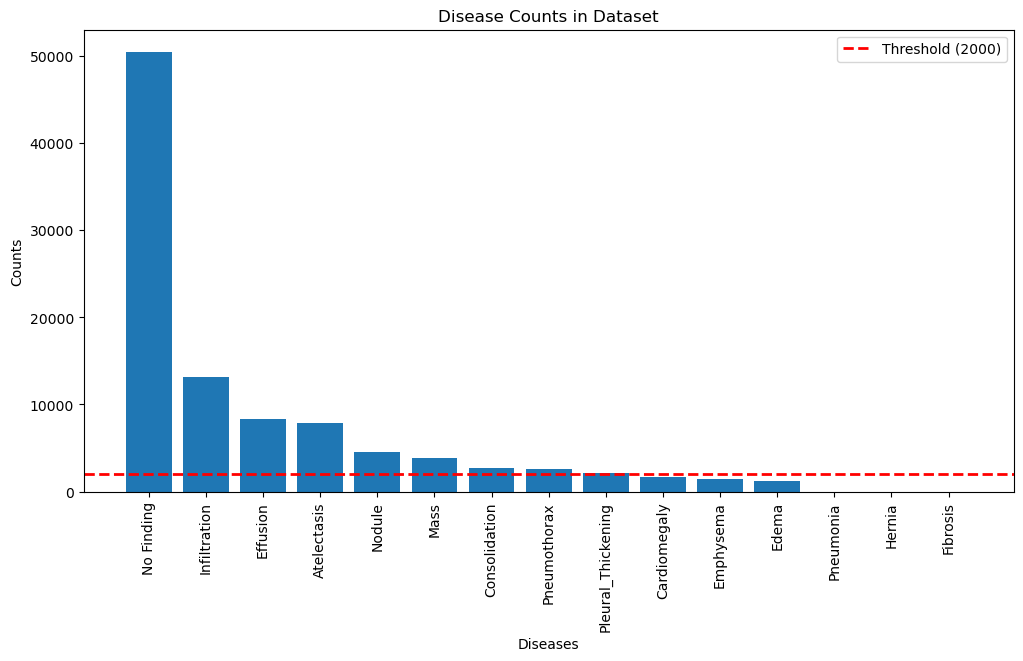

In [8]:
# We check to see how balanced the set is and check if any class is very underrepresented.
diseases=list(diseases)
counts=[df_train[i].sum() for i in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [9]:
# we remove diseases that are too rare.
rare_diseases=[i[0] for i in disease_counts if i[1]<2000]
for disease in rare_diseases:
    df_train=df_train[df_train[disease] !=1]

In [10]:
df_train=df_train[["Image Index"]+[i for i in diseases if i not in rare_diseases]]

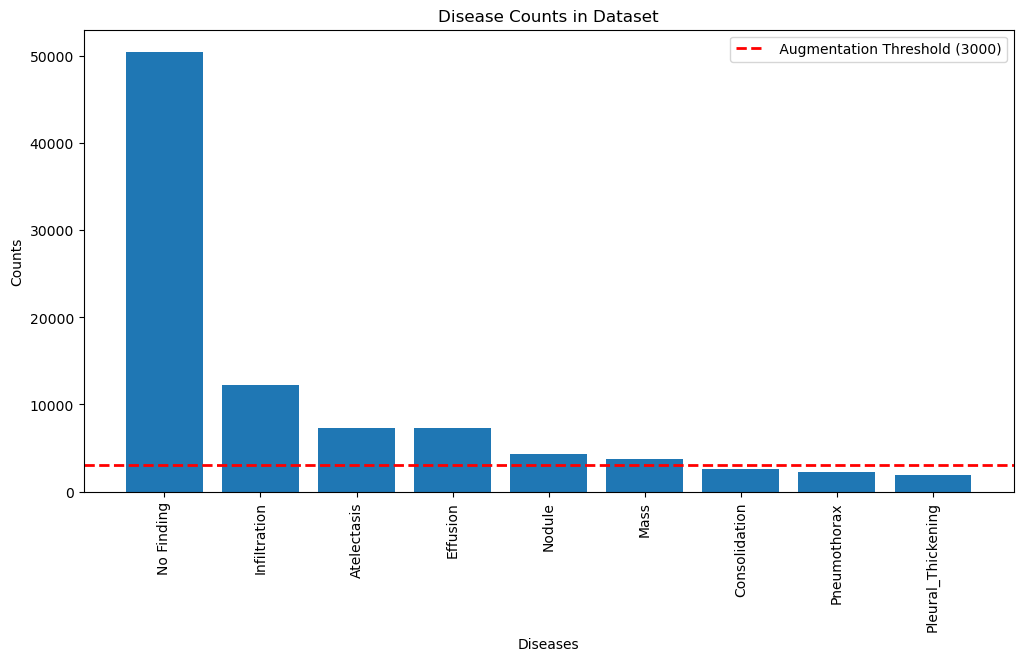

In [11]:
# We check to see how balanced the set is and check if any class is very underrepresented.
common_diseases=[i for i in diseases if i not in rare_diseases]
common_counts=[df_train[i].sum() for i in common_diseases]
common_disease_counts = sorted(zip(common_diseases, common_counts), key=lambda x: x[1], reverse=True)
sorted_common_diseases, sorted_common_counts = zip(*common_disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_common_diseases, sorted_common_counts)
plt.axhline(y=3000, color='red', linestyle='--', linewidth=2, label=' Augmentation Threshold (3000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [12]:
diseases_to_augment=[i[0] for i in common_disease_counts if i[1]<3000]

In [13]:
df_train_balanced=df_train.copy()
for disease in diseases_to_augment:
    df_disease = df_train[df_train[disease] == 1]
    num_to_add = 5000 - len(df_disease)
    
    df_augmented = pd.concat([df_disease] * (num_to_add // len(df_disease)) + [df_disease.sample(num_to_add % len(df_disease))])
    df_train_balanced = pd.concat([df_train_balanced, df_augmented])

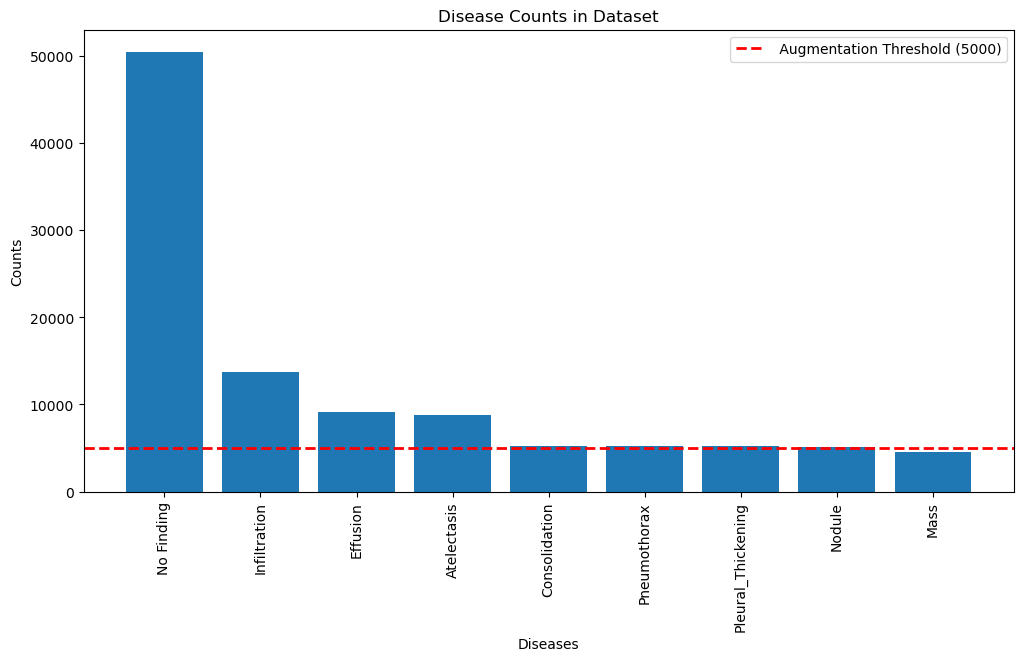

In [14]:
# We check to see how balanced the set is and check if any class is very underrepresented.
common_diseases=[i for i in diseases if i not in rare_diseases]
common_counts=[df_train_balanced[i].sum() for i in common_diseases]
common_disease_counts = sorted(zip(common_diseases, common_counts), key=lambda x: x[1], reverse=True)
sorted_common_diseases, sorted_common_counts = zip(*common_disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_common_diseases, sorted_common_counts)
plt.axhline(y=5000, color='red', linestyle='--', linewidth=2, label=' Augmentation Threshold (5000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [15]:
df_train_balanced

,Image Index,Pleural_Thickening,Consolidation,No Finding,Nodule,Atelectasis,Effusion,Pneumothorax,Mass,Infiltration
3,00000002_000.png,0,0,1,0,0,0,0,0,0
12,00000004_000.png,0,0,0,1,0,0,0,1,0
13,00000005_000.png,0,0,1,0,0,0,0,0,0
14,00000005_001.png,0,0,1,0,0,0,0,0,0
15,00000005_002.png,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
51640,00013037_002.png,1,0,0,0,0,1,0,0,0
37614,00009896_000.png,1,0,0,0,0,0,0,0,0
61610,00015212_007.png,1,0,0,0,0,0,0,1,1
62113,00015375_005.png,1,0,0,0,0,0,0,1,0


In [16]:
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)

In [21]:
image_path_dict = {path.split("\\")[-1]: path for path in image_paths}

class XrayDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict  # Dictionary for quick lookup
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['Image Index']
        image_path = self.image_path_dict[image_name]
        if image_path is None:
            raise FileNotFoundError(f"Image {image_name} not found.")
        
        image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        label = self.df.iloc[idx].iloc[1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

#Data Augmentation transform
transform = v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32, scale=True),v2.RandomRotation(degrees=(-10,10)),v2.RandomHorizontalFlip(p=0.5),v2.ColorJitter(brightness=0.1,contrast=0.1),
    v2.Resize((224, 224)),  # Converts image to tensor and normalizes to [0, 1]
    v2.Normalize([0.5], [0.5]) # Standard normalization\
    ])

# Create the dataset
dataset = XrayDataset(df_train_balanced, image_path_dict, transform=transform)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class XrayCNN(nn.Module):
    def __init__(self, num_classes):
        super(XrayCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # (16, 224, 224)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # (32, 112, 112)
        self.pool = nn.MaxPool2d(2, 2)  # Halves spatial dimensions (Max Pooling)
        self.fc1 = nn.Linear(32 * 112 * 112, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, num_classes)  # Output layer for num_classes
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Use sigmoid for multi-label classification
        return x


In [23]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss function, and optimizer
num_classes = len(df_train_balanced.columns) - 1  # Assuming each column (except 'Image Index') is a class
model = XrayCNN(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader
train_loader = DataLoader(dataset, batch_size=128,pin_memory=True, shuffle=True)

In [24]:
from tqdm import tqdm
num_epochs = 10

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for _,data in tqdm(enumerate(train_loader, 0), unit="batch", total=len(train_loader)):
        images,labels = data
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

100%|██████████| 691/691 [47:48<00:00,  4.15s/batch]


Epoch [1/10], Loss: 0.3158


100%|██████████| 691/691 [47:46<00:00,  4.15s/batch]


Epoch [2/10], Loss: 0.3032


100%|██████████| 691/691 [47:47<00:00,  4.15s/batch]


Epoch [3/10], Loss: 0.3015


100%|██████████| 691/691 [47:45<00:00,  4.15s/batch]


Epoch [4/10], Loss: 0.3002


100%|██████████| 691/691 [47:46<00:00,  4.15s/batch]


Epoch [5/10], Loss: 0.2986


100%|██████████| 691/691 [47:59<00:00,  4.17s/batch]


Epoch [6/10], Loss: 0.2962


100%|██████████| 691/691 [47:53<00:00,  4.16s/batch]


Epoch [7/10], Loss: 0.2945


100%|██████████| 691/691 [47:54<00:00,  4.16s/batch]


Epoch [8/10], Loss: 0.2922


100%|██████████| 691/691 [47:58<00:00,  4.17s/batch]


Epoch [9/10], Loss: 0.2894


100%|██████████| 691/691 [48:03<00:00,  4.17s/batch]

Epoch [10/10], Loss: 0.2872


In [ ]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient computation for faster inference
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        predictions = torch.sigmoid(outputs)  # Convert logits to probabilities
        
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

all_predictions_concat = all_predictions.reshape(-1,9)
all_labels =df_test.iloc[:,1:].values

# Binary predictions (threshold = 0.5)
binary_predictions = (all_predictions_concat > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(all_labels, binary_predictions)
auc = roc_auc_score(all_labels, all_predictions_concat, average="macro")  # For multi-label classification
f1 = f1_score(all_labels, binary_predictions, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")

In [26]:
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)
model.eval()  # Set the model to evaluation mode
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient computation for faster inference
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        predictions = torch.sigmoid(outputs)  # Convert logits to probabilities
        
        all_predictions.append(predictions.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

Testing: 100%|██████████| 192/192 [13:08<00:00,  4.10s/it]


In [72]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

all_predictions_concat = all_predictions.reshape(-1,9)
all_labels =df_test.iloc[:,1:].values

# Binary predictions (threshold = 0.5)
binary_predictions = (all_predictions_concat > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(all_labels, binary_predictions)
auc = roc_auc_score(all_labels, all_predictions_concat, average="macro")  # For multi-label classification
f1 = f1_score(all_labels, binary_predictions, average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.2183
AUC-ROC: 0.6509
F1 Score: 0.0777


In [76]:
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, binary_predictions, average="macro")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.0777


In [78]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(all_labels, all_predictions_concat, average="macro")
print(f"AUC-ROC: {auc:.4f}")

AUC-ROC: 0.6509


In [79]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, binary_predictions))

              precision    recall  f1-score   support

           0       0.18      0.01      0.02      1060
           1       0.00      0.00      0.00      1724
           2       0.59      0.47      0.52      9861
           3       0.00      0.00      0.00      1544
           4       0.40      0.00      0.00      3150
           5       0.48      0.09      0.16      4501
           6       0.50      0.00      0.00      2590
           7       0.00      0.00      0.00      1667
           8       0.50      0.00      0.00      5759

   micro avg       0.57      0.16      0.25     31856
   macro avg       0.29      0.06      0.08     31856
weighted avg       0.43      0.16      0.18     31856
 samples avg       0.21      0.20      0.20     31856



c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklea

In [70]:
all_predictions.reshape(-1,9).shape

(24526, 9)

In [80]:
df_test

,Image Index,Pleural_Thickening,Consolidation,No Finding,Nodule,Atelectasis,Effusion,Pneumothorax,Mass,Infiltration
38,00000013_000.png,0,0,1,0,0,0,0,0,0
39,00000013_001.png,0,0,0,0,0,0,1,0,0
40,00000013_002.png,0,0,0,0,0,0,1,0,0
41,00000013_003.png,1,0,0,0,0,0,0,0,0
42,00000013_004.png,0,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,0,0,1,0,0,0,0,0,0
112116,00030802_000.png,0,0,1,0,0,0,0,0,0
112117,00030803_000.png,0,0,1,0,0,0,0,0,0
112118,00030804_000.png,0,0,1,0,0,0,0,0,0


In [81]:
df_train

,Image Index,Pleural_Thickening,Consolidation,No Finding,Nodule,Atelectasis,Effusion,Pneumothorax,Mass,Infiltration
3,00000002_000.png,0,0,1,0,0,0,0,0,0
12,00000004_000.png,0,0,0,1,0,0,0,1,0
13,00000005_000.png,0,0,1,0,0,0,0,0,0
14,00000005_001.png,0,0,1,0,0,0,0,0,0
15,00000005_002.png,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,1,1,0,0,0,0,0,0,0
112100,00030789_000.png,0,0,0,0,0,0,0,0,1
112106,00030793_000.png,0,0,0,1,0,0,0,1,0
112108,00030795_000.png,1,0,0,0,0,0,0,0,0


In [1]:
torch.save(model, "my_trained_model.pth")

NameError: name 'torch' is not defined

In [2]:
import torch